In [20]:
import pandas as pd
import io

In [45]:
def parse_log_file(log_file, product):
    with open(log_file, "r") as file:
        file_content = file.read()
    sections = file_content.split("Sandbox logs:")[1].split("Activities log:")
    activities_log = sections[1].split("Trade History:")[0]
    df = pd.read_csv(io.StringIO(activities_log), sep=";", header=0)
    trade_json = pd.json_normalize(
        json.loads(sections[1].split("Trade History:")[1])
    ).to_json()
    sandbox_logs = []
    logs_data = sections[0].strip()
    start_index = 0
    while start_index < len(logs_data):
        if logs_data[start_index] == "{":
            end_index = logs_data.find("}", start_index) + 1
            log_entry = logs_data[start_index:end_index]
            sandbox_logs.append(json.loads(log_entry))
            start_index = end_index
        else:
            start_index += 1
    df_sandbox = pd.DataFrame(sandbox_logs)
    if "lambdaLog" in df_sandbox.columns:
        if df_sandbox["lambdaLog"].str.contains("IMPLIED_BID").any():
            implied_bid = pd.to_numeric(df_sandbox["lambdaLog"].str.extract(r"IMPLIED_BID: (\d+\.\d+)")[0], errors='coerce')
            implied_bid_df = pd.DataFrame({"timestamp": df_sandbox["timestamp"], "implied_bid": implied_bid, "product": "ORCHIDS"})
            df = pd.merge(df, implied_bid_df, on=["timestamp", "product"], how="left")
        if df_sandbox["lambdaLog"].str.contains("IMPLIED_ASK").any():
            implied_ask = pd.to_numeric(df_sandbox["lambdaLog"].str.extract(r"IMPLIED_ASK: (\d+\.\d+)")[0], errors='coerce')
            implied_ask_df = pd.DataFrame({"timestamp": df_sandbox["timestamp"], "implied_ask": implied_ask, "product": "ORCHIDS"})
            df = pd.merge(df, implied_ask_df, on=["timestamp", "product"], how="left")
        if df_sandbox["lambdaLog"].str.contains("FOREIGN_ASK").any():
            foreign_ask = pd.to_numeric(df_sandbox["lambdaLog"].str.extract(r"FOREIGN_ASK: (\d+\.\d+)")[0], errors='coerce')
            foreign_ask_df = pd.DataFrame({"timestamp": df_sandbox["timestamp"], "foreign_ask": foreign_ask, "product": "ORCHIDS"})
            df = pd.merge(df, foreign_ask_df, on=["timestamp", "product"], how="left")
        if df_sandbox["lambdaLog"].str.contains("FOREIGN_BID").any():
            foreign_bid = pd.to_numeric(df_sandbox["lambdaLog"].str.extract(r"FOREIGN_BID: (\d+\.\d+)")[0], errors='coerce')
            foreign_bid_df = pd.DataFrame({"timestamp": df_sandbox["timestamp"], "foreign_bid": foreign_bid, "product": "ORCHIDS"})
            df = pd.merge(df, foreign_bid_df, on=["timestamp", "product"], how="left")
    return df, trade_json, df_sandbox.to_json()

In [46]:
df, trades, _= parse_log_file('automated_test_value_3/run_0/submission.log', 'ORCHIDS')

In [47]:
df[df['product'] == 'ORCHIDS']

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,implied_bid,implied_ask,foreign_ask,foreign_bid
3,2,0,ORCHIDS,1053,7,1052.0,2.0,1046.0,46.0,1059,...,1060.0,2.0,1067.0,46.0,1056.0,0.0,1045.9,1056.0,1057.0,1055.0
13,2,100,ORCHIDS,1051,8,1050.0,2.0,1045.0,46.0,1058,...,1059.0,2.0,1065.0,46.0,1054.5,0.0,1044.9,1054.5,1055.5,1054.0
15,2,200,ORCHIDS,1051,7,1050.0,4.0,1045.0,41.0,1058,...,1059.0,4.0,1065.0,41.0,1054.5,0.0,1044.9,1054.5,1055.5,1054.0
24,2,300,ORCHIDS,1052,8,1051.0,3.0,1045.0,47.0,1059,...,1060.0,3.0,1066.0,47.0,1055.5,0.0,1045.4,1055.0,1056.0,1054.5
31,2,400,ORCHIDS,1053,9,1052.0,5.0,1046.0,58.0,1060,...,1061.0,5.0,1067.0,58.0,1056.5,0.0,1046.4,1056.0,1057.0,1055.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6966,2,99500,ORCHIDS,1044,9,1043.0,2.0,1037.0,50.0,1052,...,1053.0,2.0,1059.0,50.0,1048.0,0.0,1037.8,1046.1,1049.0,1047.0
6978,2,99600,ORCHIDS,1048,8,1047.0,3.0,1041.0,48.0,1055,...,1056.0,3.0,1062.0,48.0,1051.5,0.0,1041.3,1049.1,1052.0,1050.5
6983,2,99700,ORCHIDS,1048,10,1047.0,5.0,1041.0,56.0,1055,...,1056.0,5.0,1062.0,56.0,1051.5,0.0,1041.3,1049.1,1052.0,1050.5
6988,2,99800,ORCHIDS,1048,9,1047.0,2.0,1041.0,50.0,1055,...,1056.0,2.0,1062.0,50.0,1051.5,0.0,1041.3,1049.6,1052.5,1050.5


In [48]:
df = df[df['product'] == 'ORCHIDS'].reset_index(drop=True)

In [49]:
df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,implied_bid,implied_ask,foreign_ask,foreign_bid
0,2,0,ORCHIDS,1053,7,1052.0,2.0,1046.0,46.0,1059,...,1060.0,2.0,1067.0,46.0,1056.0,0.0,1045.9,1056.0,1057.0,1055.0
1,2,100,ORCHIDS,1051,8,1050.0,2.0,1045.0,46.0,1058,...,1059.0,2.0,1065.0,46.0,1054.5,0.0,1044.9,1054.5,1055.5,1054.0
2,2,200,ORCHIDS,1051,7,1050.0,4.0,1045.0,41.0,1058,...,1059.0,4.0,1065.0,41.0,1054.5,0.0,1044.9,1054.5,1055.5,1054.0
3,2,300,ORCHIDS,1052,8,1051.0,3.0,1045.0,47.0,1059,...,1060.0,3.0,1066.0,47.0,1055.5,0.0,1045.4,1055.0,1056.0,1054.5
4,2,400,ORCHIDS,1053,9,1052.0,5.0,1046.0,58.0,1060,...,1061.0,5.0,1067.0,58.0,1056.5,0.0,1046.4,1056.0,1057.0,1055.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,99500,ORCHIDS,1044,9,1043.0,2.0,1037.0,50.0,1052,...,1053.0,2.0,1059.0,50.0,1048.0,0.0,1037.8,1046.1,1049.0,1047.0
996,2,99600,ORCHIDS,1048,8,1047.0,3.0,1041.0,48.0,1055,...,1056.0,3.0,1062.0,48.0,1051.5,0.0,1041.3,1049.1,1052.0,1050.5
997,2,99700,ORCHIDS,1048,10,1047.0,5.0,1041.0,56.0,1055,...,1056.0,5.0,1062.0,56.0,1051.5,0.0,1041.3,1049.1,1052.0,1050.5
998,2,99800,ORCHIDS,1048,9,1047.0,2.0,1041.0,50.0,1055,...,1056.0,2.0,1062.0,50.0,1051.5,0.0,1041.3,1049.6,1052.5,1050.5


In [50]:
for i in range(0, 13):
    level = i - 6
    _, trades_level_json, _ = parse_log_file(f'automated_test_value_3/run_{i}/submission.log', 'ORCHIDS')
    trades_level_df = pd.read_json(trades_level_json)
    trades_level_df = trades_level_df[trades_level_df['symbol'] == 'ORCHIDS']
    trades_level_df = trades_level_df[['timestamp', 'price', 'quantity']]
    trades_level_df = trades_level_df.rename(columns={'price': f'price_level_{level}', 'quantity': f'quantity_level_{level}'})
    
    # Group by timestamp and aggregate price and quantity
    trades_level_df = trades_level_df.groupby('timestamp').agg({
        f'price_level_{level}': 'min',
        f'quantity_level_{level}': 'sum'
    }).reset_index()
    
#     display(trades_level_df)
    df = df.merge(trades_level_df, on="timestamp", how='left')
#     display(df)

/var/folders/qd/7_02v1xx1nx_p2rj9mxjqzzh0000gn/T/ipykernel_29162/74622569.py:4: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/var/folders/qd/7_02v1xx1nx_p2rj9mxjqzzh0000gn/T/ipykernel_29162/74622569.py:4: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/var/folders/qd/7_02v1xx1nx_p2rj9mxjqzzh0000gn/T/ipykernel_29162/74622569.py:4: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

/var/folders/qd/7_02v1xx1nx_p2rj9mxjqzzh0000gn/T/ipykernel_29162/74622569.py:4: FutureWarning:

Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' objec

In [51]:
df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,price_level_2,quantity_level_2,price_level_3,quantity_level_3,price_level_4,quantity_level_4,price_level_5,quantity_level_5,price_level_6,quantity_level_6
0,2,0,ORCHIDS,1053,7,1052.0,2.0,1046.0,46.0,1059,...,NaN,NaN,1054.0,100.0,1053.0,100.0,1052,100,1051,100
1,2,100,ORCHIDS,1051,8,1050.0,2.0,1045.0,46.0,1058,...,1054.0,100.0,1053.0,100.0,1052.0,100.0,1051,100,1050,100
2,2,200,ORCHIDS,1051,7,1050.0,4.0,1045.0,41.0,1058,...,1054.0,100.0,1053.0,100.0,1052.0,100.0,1051,100,1050,100
3,2,300,ORCHIDS,1052,8,1051.0,3.0,1045.0,47.0,1059,...,1054.0,100.0,1053.0,100.0,1052.0,100.0,1051,100,1050,100
4,2,400,ORCHIDS,1053,9,1052.0,5.0,1046.0,58.0,1060,...,1055.0,100.0,1054.0,100.0,1053.0,100.0,1052,100,1051,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,99500,ORCHIDS,1044,9,1043.0,2.0,1037.0,50.0,1052,...,NaN,NaN,1046.0,100.0,1045.0,100.0,1044,100,1043,100
996,2,99600,ORCHIDS,1048,8,1047.0,3.0,1041.0,48.0,1055,...,NaN,NaN,NaN,NaN,1048.0,8.0,1047,11,1047,11
997,2,99700,ORCHIDS,1048,10,1047.0,5.0,1041.0,56.0,1055,...,NaN,NaN,NaN,NaN,1048.0,10.0,1047,15,1047,15
998,2,99800,ORCHIDS,1048,9,1047.0,2.0,1041.0,50.0,1055,...,NaN,NaN,NaN,NaN,1048.0,9.0,1047,11,1047,11


In [52]:
df[([f"price_level_{i}" for i in range(-6, 7)] + [f"quantity_level_{i}" for i in range(-6, 7)])].mean()

price_level_-6       1051.857143
price_level_-5       1051.857143
price_level_-4       1051.857143
price_level_-3       1051.857143
price_level_-2       1051.857143
price_level_-1       1051.894737
price_level_0        1051.600000
price_level_1        1052.234568
price_level_2        1052.409709
price_level_3        1051.553459
price_level_4        1050.277652
price_level_5        1049.366000
price_level_6        1048.574000
quantity_level_-6       3.714286
quantity_level_-5       3.714286
quantity_level_-4       3.714286
quantity_level_-3       3.714286
quantity_level_-2       3.714286
quantity_level_-1       3.684211
quantity_level_0        3.750000
quantity_level_1       56.925926
quantity_level_2       95.823301
quantity_level_3       97.823899
quantity_level_4       72.426637
quantity_level_5       65.877000
quantity_level_6       66.380000
dtype: float64

In [53]:
# Create a boolean mask for rows where any quantity level is greater than or equal to 90
mask = df[[f'quantity_level_{i}' for i in range(7)]].ge(100).any(axis=1)

# Create a new dataframe with the filtered rows
df_limit = df[mask]

In [54]:
df_limit

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,price_level_2,quantity_level_2,price_level_3,quantity_level_3,price_level_4,quantity_level_4,price_level_5,quantity_level_5,price_level_6,quantity_level_6
0,2,0,ORCHIDS,1053,7,1052.0,2.0,1046.0,46.0,1059,...,NaN,NaN,1054.0,100.0,1053.0,100.0,1052,100,1051,100
1,2,100,ORCHIDS,1051,8,1050.0,2.0,1045.0,46.0,1058,...,1054.0,100.0,1053.0,100.0,1052.0,100.0,1051,100,1050,100
2,2,200,ORCHIDS,1051,7,1050.0,4.0,1045.0,41.0,1058,...,1054.0,100.0,1053.0,100.0,1052.0,100.0,1051,100,1050,100
3,2,300,ORCHIDS,1052,8,1051.0,3.0,1045.0,47.0,1059,...,1054.0,100.0,1053.0,100.0,1052.0,100.0,1051,100,1050,100
4,2,400,ORCHIDS,1053,9,1052.0,5.0,1046.0,58.0,1060,...,1055.0,100.0,1054.0,100.0,1053.0,100.0,1052,100,1051,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,2,99100,ORCHIDS,1047,9,1046.0,4.0,1040.0,54.0,1054,...,1049.0,100.0,1048.0,100.0,1047.0,100.0,1046,100,1045,100
992,2,99200,ORCHIDS,1045,5,1044.0,4.0,1038.0,37.0,1052,...,1047.0,100.0,1046.0,100.0,1045.0,100.0,1044,100,1043,100
993,2,99300,ORCHIDS,1044,7,1043.0,3.0,1037.0,42.0,1051,...,1046.0,100.0,1045.0,100.0,1044.0,100.0,1043,100,1042,100
994,2,99400,ORCHIDS,1045,10,1044.0,3.0,1038.0,55.0,1052,...,1047.0,100.0,1046.0,100.0,1045.0,100.0,1044,100,1043,100


In [55]:
df_limit[[f'quantity_level_{i}' for i in range(0, 7)]]

,quantity_level_0,quantity_level_1,quantity_level_2,quantity_level_3,quantity_level_4,quantity_level_5,quantity_level_6
0,NaN,NaN,NaN,100.0,100.0,100,100
1,NaN,NaN,100.0,100.0,100.0,100,100
2,NaN,NaN,100.0,100.0,100.0,100,100
3,NaN,NaN,100.0,100.0,100.0,100,100
4,NaN,NaN,100.0,100.0,100.0,100,100
...,...,...,...,...,...,...,...
991,NaN,NaN,100.0,100.0,100.0,100,100
992,NaN,NaN,100.0,100.0,100.0,100,100
993,NaN,NaN,100.0,100.0,100.0,100,100
994,NaN,NaN,100.0,100.0,100.0,100,100


In [56]:
# Create a new dataframe with the quantity level columns
quantity_cols = [f'quantity_level_{i}' for i in range(7)]
quantity_df = df_limit[quantity_cols]

# Replace values not equal to 100 with NaN
quantity_df = quantity_df.where(quantity_df == 100)

# Find the index of the first column with value 100 for each row
best_level = quantity_df.apply(lambda row: row.first_valid_index(), axis=1)

# Extract the level number from the column name
df_limit['best_level'] = best_level.str.extract('(\d+)', expand=False).astype(float)

/var/folders/qd/7_02v1xx1nx_p2rj9mxjqzzh0000gn/T/ipykernel_29162/2335216210.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:

df_limit['best_level'].value_counts()

best_level
2.0    445
3.0    126
1.0     42
Name: count, dtype: int64

In [59]:
df_limit.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'implied_bid', 'implied_ask', 'foreign_ask', 'foreign_bid',
       'price_level_-6', 'quantity_level_-6', 'price_level_-5',
       'quantity_level_-5', 'price_level_-4', 'quantity_level_-4',
       'price_level_-3', 'quantity_level_-3', 'price_level_-2',
       'quantity_level_-2', 'price_level_-1', 'quantity_level_-1',
       'price_level_0', 'quantity_level_0', 'price_level_1',
       'quantity_level_1', 'price_level_2', 'quantity_level_2',
       'price_level_3', 'quantity_level_3', 'price_level_4',
       'quantity_level_4', 'price_level_5', 'quantity_level_5',
       'price_level_6', 'quantity_level_6', 'best_level'],
      dtype='object')

In [60]:
df_limit['best_level'] = -df_limit['best_level']

/var/folders/qd/7_02v1xx1nx_p2rj9mxjqzzh0000gn/T/ipykernel_29162/2622942822.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
import plotly.graph_objects as go

# Create a new figure
fig = go.Figure()

# Define the columns to plot
columns_to_plot = ['bid_price_1', 'bid_price_2', 'bid_price_3',
                   'ask_price_1', 'ask_price_2', 'ask_price_3',
                   'mid_price', 'implied_bid', 'implied_ask',
                   'foreign_ask', 'foreign_bid']

# Add traces for each column
for col in columns_to_plot:
    fig.add_trace(go.Scatter(x=df_limit['timestamp'], y=df_limit[col], name=col))

# Add a trace for best_level on a separate y-axis
fig.add_trace(go.Scatter(x=df_limit['timestamp'], y=df_limit['best_level'], name='Best Level', yaxis='y2'))

# Configure the layout
fig.update_layout(
    title='Price and Best Level vs. Timestamp',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Price'),
    yaxis2=dict(title='Best Level', overlaying='y', side='right', range=[-2, 0], tickvals=[-2, -1, 0,]),
    legend=dict(x=1.1, y=1, orientation='v'),
    width=800,
    height=500
)

# Display the plot
fig.show()

In [62]:
df_limit['best_level'] = -df_limit['best_level']

import plotly.graph_objects as go

# Create a new figure
fig = go.Figure()

# Define the columns to plot
columns_to_plot = ['bid_price_1', 'bid_price_2', 'bid_price_3',
                   'ask_price_1', 'ask_price_2', 'ask_price_3',
                   'mid_price', 'implied_bid', 'implied_ask',
                   'foreign_ask', 'foreign_bid']

# Add traces for each column
for col in columns_to_plot:
    if 'bid_price' in col:
        bid_volume_col = col.replace('price', 'volume')
        hovertemplate = f'Timestamp: %{{x}}<br>{col}: %{{y}}<br>{bid_volume_col}: %{{customdata}}'
        customdata = df_limit[bid_volume_col]
    elif 'ask_price' in col:
        ask_volume_col = col.replace('price', 'volume')
        hovertemplate = f'Timestamp: %{{x}}<br>{col}: %{{y}}<br>{ask_volume_col}: %{{customdata}}'
        customdata = df_limit[ask_volume_col]
    else:
        hovertemplate = f'Timestamp: %{{x}}<br>{col}: %{{y}}'
        customdata = None

    fig.add_trace(go.Scatter(x=df_limit['timestamp'], y=df_limit[col], name=col,
                             hovertemplate=hovertemplate, customdata=customdata))

# Add a trace for best_level on a separate y-axis
fig.add_trace(go.Scatter(x=df_limit['timestamp'], y=df_limit['best_level'], name='Best Level', yaxis='y2',
                         hovertemplate='Timestamp: %{x}<br>Best Level: %{y}'))

# Configure the layout
fig.update_layout(
    title='Price and Best Level vs. Timestamp',
    xaxis=dict(title='Timestamp'),
    yaxis=dict(title='Price'),
    yaxis2=dict(title='Best Level', overlaying='y', side='right', range=[-2, 0], tickvals=[-2, -1, 0]),
    legend=dict(x=1.1, y=1, orientation='v'),
    width=800,
    height=500,
    hovermode='x unified',
    hoverlabel=dict(font=dict(size=8))  # Adjust the font size of the hover labels
)

# Display the plot
fig.show()

/var/folders/qd/7_02v1xx1nx_p2rj9mxjqzzh0000gn/T/ipykernel_29162/4183601796.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



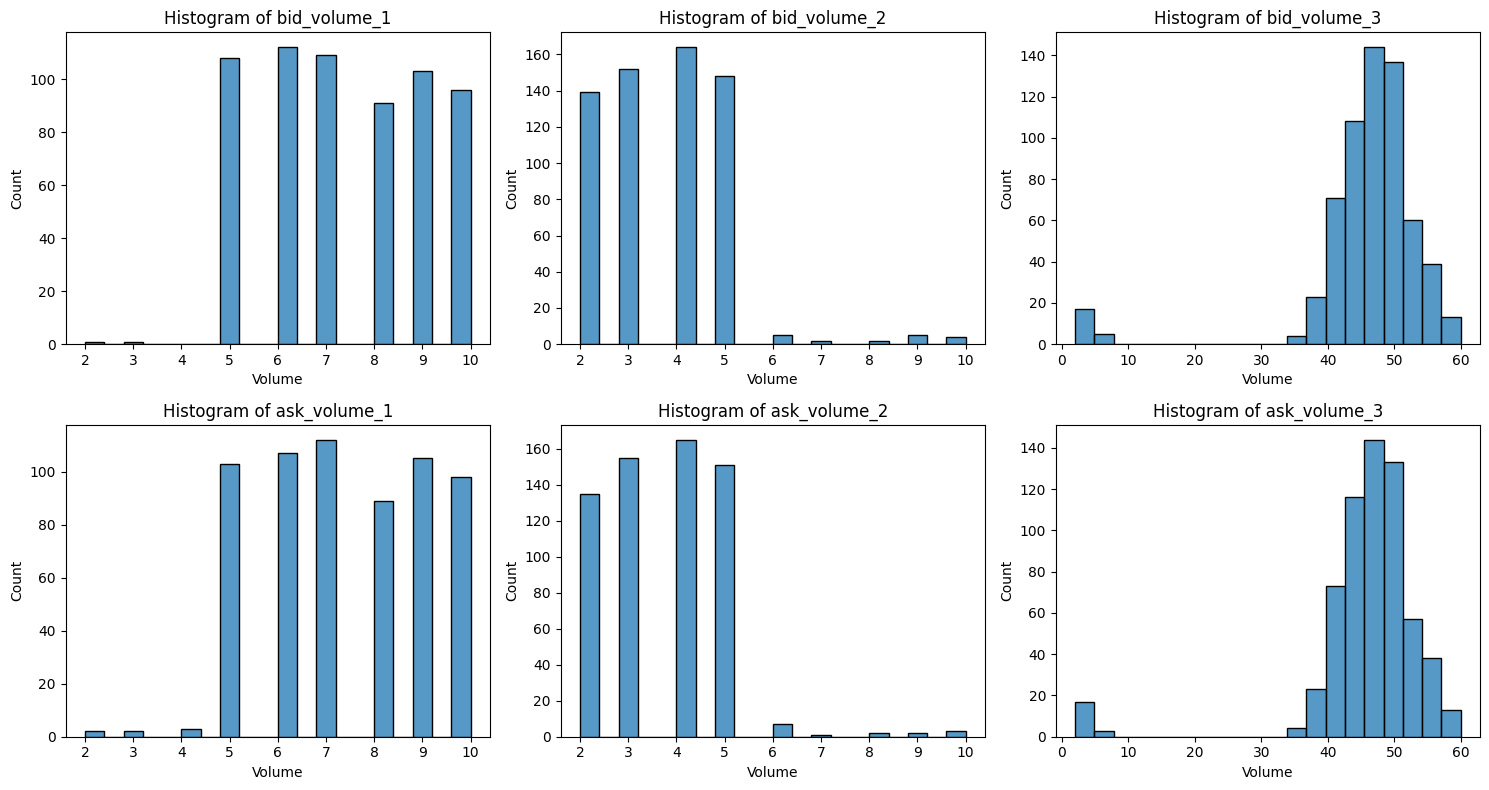

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns for bid and ask volumes
bid_volume_cols = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3']
ask_volume_cols = ['ask_volume_1', 'ask_volume_2', 'ask_volume_3']

# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot the histograms for bid volumes
for i, col in enumerate(bid_volume_cols):
    sns.histplot(data=df_limit, x=col, bins=20, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel('Count')

# Plot the histograms for ask volumes
for i, col in enumerate(ask_volume_cols):
    sns.histplot(data=df_limit, x=col, bins=20, ax=axes[i+3])
    axes[i+3].set_title(f'Histogram of {col}')
    axes[i+3].set_xlabel('Volume')
    axes[i+3].set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()